 # Facial Recognition Using Vgg Face
 
 
The VGG-Face is a deep-CNN created by Department of Engineering Science, University of Oxford. [HOMEPAGE CLICK HERE](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)

This deep-CNN has been trained using Softmax loss to recognize faces of 2,622 celebrity identities. It implements VGG-Very-Deep-16 CNN architecture as described in a [paper](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf) published in 2015.

The model architecture is a linear sequence of layer transformations of the following types:
* Convolution + ReLU activations
* MaxPooling
* softmax
<img src="https://image.slidesharecdn.com/tfmandreavideoretrievalofspecificpersonsinspecificlocations-160920130647/95/video-retrieval-of-specific-persons-in-specific-locations-23-638.jpg?cb=1474377027" height="311" width="533">

## Vgg16 vs Vgg Face

Briefly, the VGG-Face model is the same NeuralNet architecture as the VGG16 model used to identity 1000 classes of object in the ImageNet competition. 
The VGG16 name simply states the model originated from the Visual Geometry Group and that it was 16 trainable layers. 
The main difference between the VGG16-ImageNet and VGG-Face model is the set of calibrated weights as the training sets were different.

## In this jupyter notebook, we did:
* Load vgg-face 
* Detect and crop faces from input picture using OpenCV
* Predict name from crpped faces
* Remove image mean and predict again

Load we load some important standard packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import copy
%matplotlib inline

Then we load the appropriate Keras packages.

In [2]:
import keras.backend as K
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

Using TensorFlow backend.


Clear the Keras session.

In [3]:
K.clear_session()

Set the dimensions of the input image. Vgg-face only takes input size as (244,244,3).

In [4]:
nrow = 224
ncol = 224

## Using pre trained vgg face network

Create a model using VGG-Face and its pre-trained weight matrix. 

When you use it for the first time ,weights are downloaded and stored in ~/.keras folder.

It's very important to set input shape.

In [5]:
model = VGGFace(model='vgg16', 
                weights='vggface',
                input_shape=(nrow,ncol,3)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

We import the weight matrix by ourself and save the names in description.

In [6]:
from scipy.io import loadmat

data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', 
               matlab_compatible=False, 
               struct_as_record=False)

net = data['net'][0,0]
l = net.layers
description = net.classes[0,0].description
print(description)

[[array(['A.J._Buckley'], 
      dtype='<U12')]
 [array(['A.R._Rahman'], 
      dtype='<U11')]
 [array(['Aamir_Khan'], 
      dtype='<U10')]
 ..., 
 [array(['Zsa_Zsa_Gabor'], 
      dtype='<U13')]
 [array(['Zulay_Henao'], 
      dtype='<U11')]
 [array(['Zuleyka_Silver'], 
      dtype='<U14')]]


Let use a photo of Aamir Khan to test how Vgg Face predicts. 
 What should be known is that this photo is well cropped and resized and centralized to satify the input requirements of vgg face. Most of the pictures found on the Internet will not be this ideal.

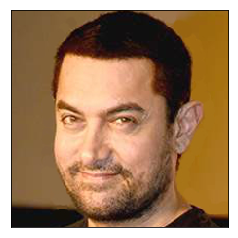

In [7]:
imagePath = 'ak.png'

image = Image.open(imagePath)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

Before predict, we should transform this image into a (224,224,3) numpy array with float values. Also, check the summary of the model, we could find that the output shape of first input layer is (None, 224, 224, 3), so this numpy array should expand to four dimensions to fit in this model.

After prediction, we find the final output is a 2622 array, which contains the posibilities of whether this photo should be someone. For example, if the third value of output is 0.004, which means that this face is less likely to be the person labeled no.3. And if the fifth value is 0.974, then the fifth name in the dataset is most likely to have this face.

In [8]:
imarr = np.array(image).astype(np.float32)
imarr = np.expand_dims(imarr, axis=0)
out = model.predict(imarr)

print(out.shape)
print(out)

(1, 2622)
[[  2.73310816e-05   1.30483590e-04   9.62419510e-01 ...,   2.92022637e-08
    2.01398302e-06   1.64550855e-07]]


So we need to find the max value of the predict output. Since it is probablity, we need to save the index of this max value, and look for the name according to this index in description, the data we extract from weight matrix.

The result shows it is 96.2% to be Aamia Khan, which is quite nice.

In [9]:
max_index = np.argmax(out, axis=1)[0]
max_name = description[max_index,0]
print(max_index, max_name[0], out[0,max_index])

2 Aamir_Khan 0.96242


##  Detect and crop faces from normal photos 
##  Using OpenCV

Vgg Face is trained with well prepared photos. Let's look at the very first picture in vgg face dataset. It is picture of A.C.Burkey. But in its dataset, the detail of this picture is 'http://www.contactmusic.com/pics/ld/active_for_life_arrivals_090110/a.j_buckley_2706152.jpg 165.21 105.50 298.57 238.86 4.00 3.59 1
'. The numbers after url point to the location of his face. And when training, they only use his face as the input, instead of the whole picture.
<img src="http://www.contactmusic.com/pics/ld/active_for_life_arrivals_090110/a.j_buckley_2706152.jpg" height="500" width="160">

So the next thing we should do is to prepare input photos download from internet to only have the face. Of course we can't just reshape the picture because it might twist it. And we can;t just the same method in MINST lab, because we are finding faces this time, and faces are found by facial features. Also, most of the pictures of celebrities would includes other celebrities as well. Thinking of finding your favorite actor in a group photo of oscar. We need some other method to find faces. 
<img src="https://www.nanrenwo.net/uploads/allimg/151120/8388-1511200Z418-51.jpg" height="240" width="260">

We considered using OpenCV to find faces.OpenCV is the most popular library for computer vision. It uses machine learning algorithms to search for faces within a picture. For something as complicated as a face, there isn’t one simple test that will tell you if it found a face or not. Instead, there are thousands of small patterns/features that must be matched. The algorithms break the task of identifying the face into thousands of smaller, bite-sized tasks, each of which is easy to solve. These tasks are also called classifiers. OpenCV uses cascades to detect these features.
 
Casade is like a series of waterfalls, the OpenCV cascade breaks the problem of detecting faces into multiple stages. For each block, it does a very rough and quick test. If that passes, it does a slightly more detailed test, and so on. The algorithm may have 30-50 of these stages or cascades, and it will only detect a face if all stages pass. The advantage is that the majority of the pictures will return negative during the first few stages, which means the algorithm won’t waste too much time detect thounands of features.

The cascades themselves are just a bunch of XML files that contain OpenCV data used to detect objects. 

Now we create the cascade and initialize it with our face cascade. We use haarcascade_frontalface_default.xml. It can be downloaded from [here](http:https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml).

This loads the face cascade into memory so it’s ready for use. 

In [10]:
import cv2
imagePath = 'cf.jpg'
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Read the image
# Convert it to grayscale. Many operations in OpenCv are done in grayscale.
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Then we use the function detectMultiScale to detect faces. 

* The detectMultiScale function is a general function that detects objects. Since we are calling it on the face cascade, that’s what it detects. The first option is the grayscale image.

* The second is the scaleFactor. Since some faces may be closer to the camera, they would appear bigger than those faces in the back. The scale factor compensates for this.

* The detection algorithm uses a moving window to detect objects. minNeighbors defines how many objects are detected near the current one before it declares the face found. minSize, meanwhile, gives the size of each window.

The function returns a list of rectangles where it believes it found a face.
We use the picture of Jackie Chan and Bing Bing Fan.

In [11]:
# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.2,
    minNeighbors=5,
    minSize=(30, 30)
)
faces = faceCascade.detectMultiScale(gray, 1.2, 5)
print("Found {0} faces!".format(len(faces)))

print(faces)

Found 2 faces!
[[145 113 107 107]
 [228  16 115 115]]


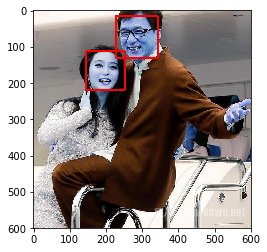

In [12]:
# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

plt.imshow(image)
plt.show()

Then we created a function called pred to predict the name.

In [13]:
def pred(model, crpimg):
    imarr = np.array(crpimg).astype(np.float32)

    imarr = np.expand_dims(imarr, axis=0)
    out = model.predict(imarr)

    max_index = np.argmax(out, axis=1)[0]
    max_name = description[max_index,0]
    print(max_index, max_name[0], out[0,max_index])

## Predict name from crpped faces

Now we crop the faces from the rectangles and use cropped pictures to predict.

First make a function to predict face by face：

In [15]:
def face_recon (im, n, faces, model):
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        center_x = x+w/2
        center_y = y+h/2
        b_dim = min(max(w,h)*1.1,im.width, im.height) 
        box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
        
        # Crop Image
        crpim = im.crop(box).resize((224,224))
    
        plt.imshow(np.asarray(crpim))
        plt.show()
    
        pred(model, crpim)

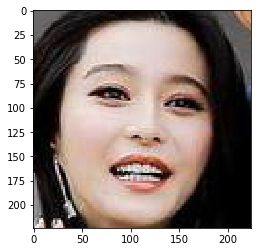

221 Bingbing_Fan 0.849964


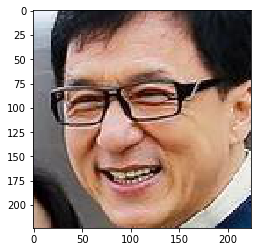

396 Clark_Duke 0.140847


In [17]:
im = Image.open(imagePath)
face_recon(im, len(faces), faces, model)    

Well the prediction works well on Bingbing, but not on Jackie Chan.

Beause the training set of Jackie Chan does not includes pictures of him . 

But Clark Duke shows around with his glasses every time, and they indeed look like each other. So the prediction is Clark Duke. Which makes sense.
<img src="https://www.aceshowbiz.com/images/photo/clark_duke.jpg">

So let try with another picture with multiple faces, and with only bare faces with no glasses.

The photo below is the poster of movie *Twilight*. It incldes the three main charaters of it.

The result is good. However, Robert Pattinson has the least possilibility to be himself. This is because he plays a vampire in this movie, and it slightly changes his appearance from real life. And the other two actors are still human in this movie, so the probabilities are higher. 

Which indicates that the result is closely related to the training dataset.

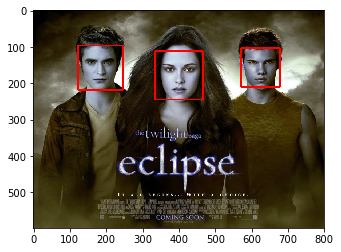

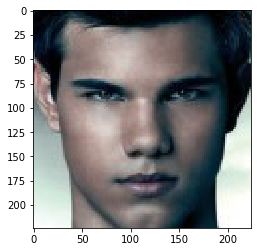

2420 Taylor_Lautner 0.993213


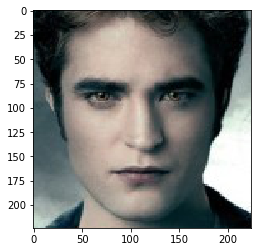

2102 Robert_Pattinson 0.871177


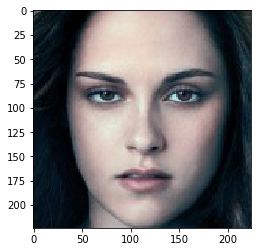

1409 Kristen_Stewart 0.999729


In [27]:
imagePath = 'mg.jpg'
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.2,
    minNeighbors=5,
    minSize=(30, 30))

faces = faceCascade.detectMultiScale(gray, 1.2, 5)

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)

plt.imshow(image)
plt.show()

im = Image.open(imagePath)
face_recon(im, len(faces), faces, model)  

##  Remove image mean and predict again

During our research, we found that when people are using imagenet, they tend to extract mean of the photo before prediction. 

So we tried to modified our *predict* function to zero-center by mean pixel before prediction.

Based on [this](https://github.com/rcmalli/keras-vggface) and [this] (https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py) page.

This function did:
* Remove image mean
* im[:, :, 0] -= 93.5940
* im[:, :, 1] -= 104.7624
* im[:, :, 2] -= 129.1863


In [25]:
from keras_vggface import utils

def modified_pred(model, crpimg):
    imarr = np.array(crpimg).astype(np.float32)

    imarr = np.expand_dims(imarr, axis=0)
    # Extract mean frome picture
    imarr = utils.preprocess_input(imarr, version=1)
    out = model.predict(imarr)

    max_index = np.argmax(out, axis=1)[0]
    max_name = description[max_index,0]
    print(max_index, max_name[0], out[0,max_index])
    
def modified_face_recon (im, n, faces, model):
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        center_x = x+w/2
        center_y = y+h/2
        b_dim = min(max(w,h)*1.1,im.width, im.height) 
        box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
        
        # Crop Image
        crpim = im.crop(box).resize((224,224))
    
        plt.imshow(np.asarray(crpim))
        plt.show()
    
        modified_pred(model, crpim)    

Let's do the prediction on *Twilight* again, 

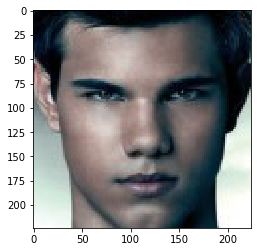

2420 Taylor_Lautner 0.984899


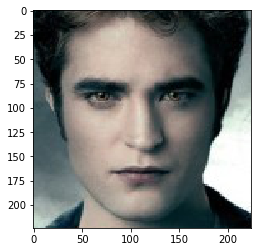

2102 Robert_Pattinson 0.732076


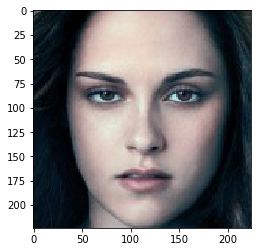

1409 Kristen_Stewart 0.989218


In [28]:
modified_face_recon(im, len(faces), faces, model)  

Comparing to the result without mean extracting, this result is slightly worse.

But [this](http://www.pythonexample.com/code/a-basic-interpersonal-communication-model/) code paper says this would be more robust.